In [1]:
%matplotlib nbagg
from tqdm import tqdm_notebook as tqdm
import itertools

import numpy as np
from scipy import stats, signal, ndimage
import scipy.integrate as spint
import scipy.interpolate as spolate 
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from colorednoise import powerlaw_psd_gaussian as gen_noise

In [108]:
n_probes = 16
points = np.array([np.arange(n_probes) - (n_probes+1)/2,
                   np.zeros(n_probes), np.zeros(n_probes)]) * 5

In [184]:
D = 2 # Diffusion constant, um^2 / ms
dt = 1
tmax = 1000

# Tensor product grid in micron units.
X = Y = Z = np.linspace(points.min(), points.max(), 51)*3
dx, dy, dz = X[1] - X[0], Y[1] - Y[0], Z[1] - Z[0]

# Areal charge distribution, in fC / um^3
rho = np.zeros(X.shape + Y.shape + Z.shape)


# Distance in microns between each probe point 
# and each point of the grid. 
r = np.sqrt((X[:,None,None] - points[0,:,None,None,None])**2 +
            (Y[None,:,None] - points[1,:,None,None,None])**2 +
            (Z[None,None,:] - points[2,:,None,None,None])**2)

# Quantize each probe point to a grid point.
x,y,z = np.unravel_index(np.argmin(r.reshape((16,-1)), axis=1), r.shape[1:])

# Initial delta function near grid point 3.
rho[x[3],y[3],z[3]] = 1e4

In [185]:
# Force minimum value to be half the size of a grid
# point since there's no meaning to anything smaller.
min_r = np.sqrt((dx**2 + dy**2 + dz**2))/2
r = np.maximum(r, min_r)

# A factor to divide the integral by to calculate the
# potential due to the charge distribution. Normally, 
# this should be 4pi * permittivity, but here I get  
# the right value if it's 10^6 times larger than that.
# BUUUUUTTTT WHYYYYYYY??????
# The problem is NOT units! If I convert to all SI, 
# everything is still too big by the same factor.
eps_factor = 4 * np.pi * 80 * 8.854187 # pF/um

# Standard deviation of the Gaussian blur which approximates
# a single timestep of the diffusion process. It should be
# sqrt(D dt), but for the function we're using, it needs to be
# expressed in grid points rather than real units, so divide
# by the grid spacing.
sigma = np.sqrt(2*D*dt)/np.array([dx, dy, dz])
print('Kernel size', np.int32(2*4*sigma+1))

states = np.zeros((tmax, n_probes))
for t in tqdm(range(tmax)):
    
    # This Gaussian blur approximates diffusion. Also assume 
    # that charge distribution is neutral outside the region.
    # Note that this assumption creates boundary effects, so 
    # always make sure the grid extends past the organoid!
    rho = ndimage.gaussian_filter(rho, sigma=sigma, mode='constant')
    
    # For each probe, find the voltage by integrating the point
    # charges contributed by the areal charge density rho.
    # states[t,:] = spint.simps(spint.simps(spint.simps(rho/r, Z), Y), X) / eps_factor
    states[t,:] = rho[x,y,z]
    

Kernel size [4 4 4]


<IPython.core.display.Javascript object>


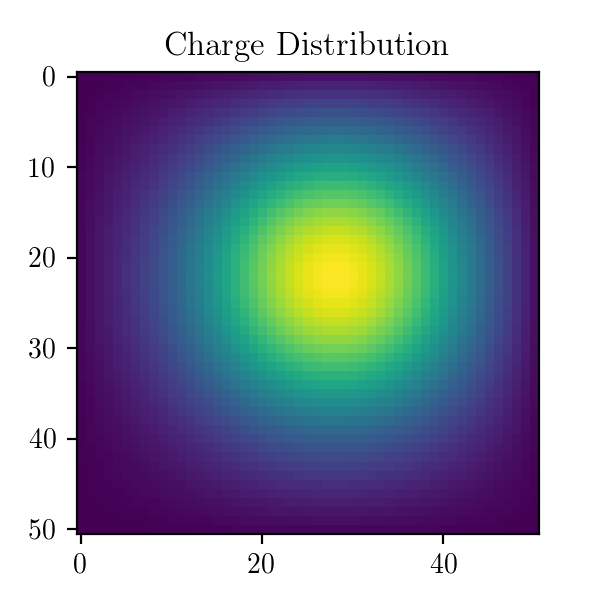

In [192]:
plt.figure(figsize=(3,3))
plt.imshow(rho[:,:,z[3]])
plt.title('Charge Distribution')
plt.savefig('chargedist.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


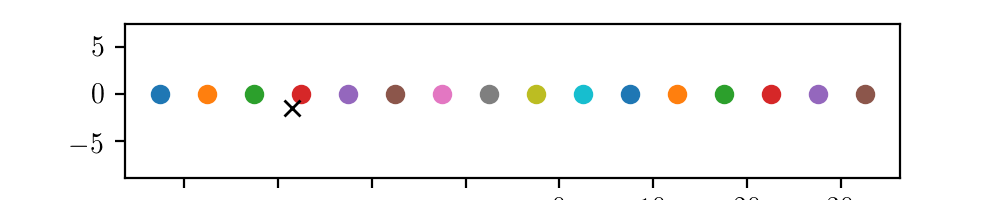

(-46.25, 36.25, -1.575, 0.07500000000000001)

In [187]:
plt.figure(figsize=(5,1))
for i in range(n_probes):
    plt.plot(points[0,i], points[1,i], 'o')
plt.plot(X[x[3]], Y[y[3]], 'kx')
plt.axis('equal')

<IPython.core.display.Javascript object>


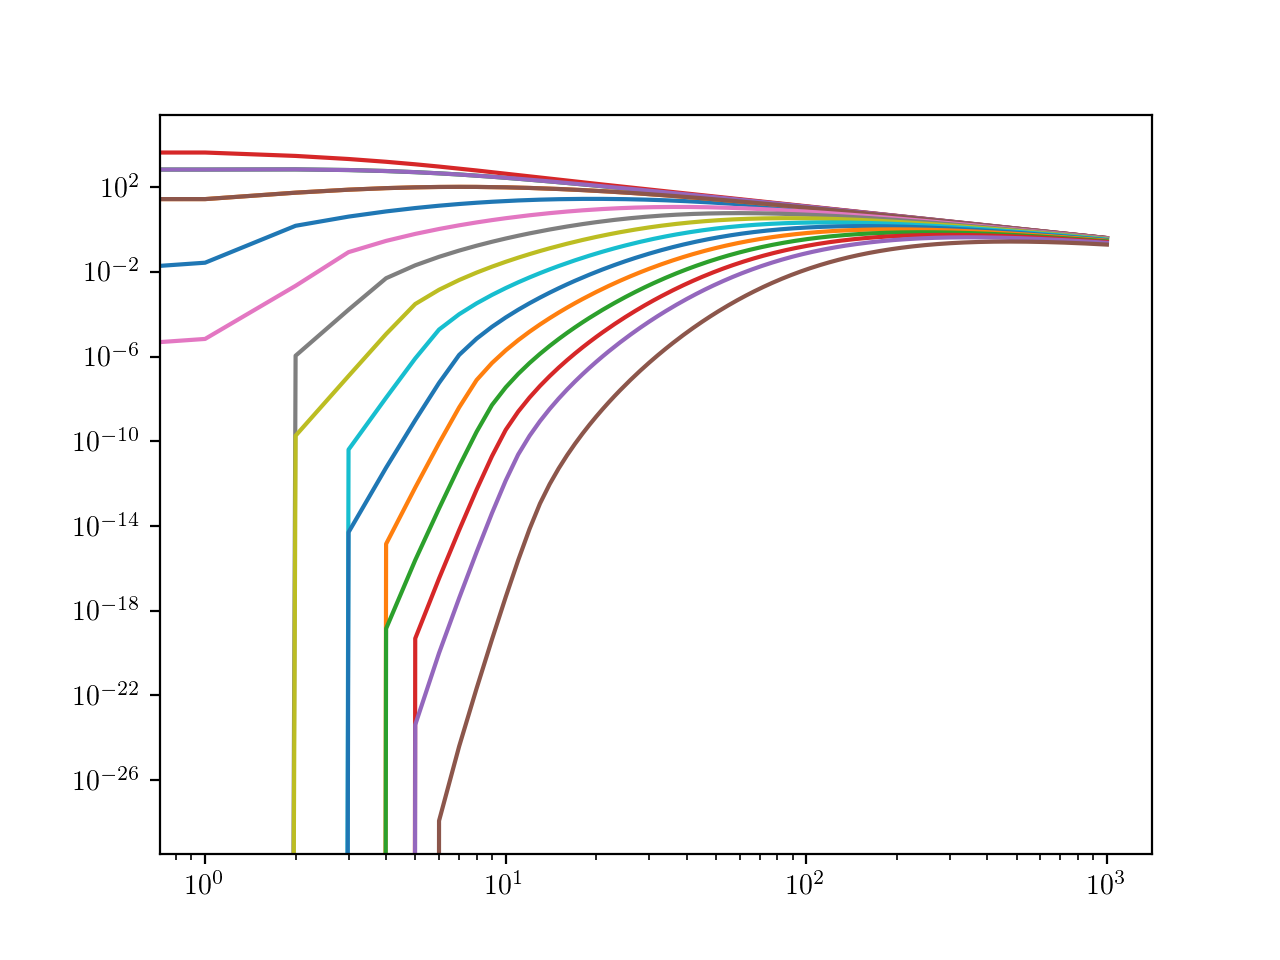

In [188]:
plt.figure()
plt.loglog(range(tmax), states)
None